In [1]:
# Libraries and utilities

import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix
)

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import learning_curve

from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [87]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

# One-hot encoding for test and train
cat_var=["statement","repetition","sex","emotional_intensity","vocal_channel"]
le=preprocessing.LabelEncoder()
for i in cat_var:
    df_train[i]=le.fit_transform(df_train[i])
    df_test[i]=le.fit_transform(df_test[i])
categorical_col = ["emotion"]

df_train = pd.get_dummies(df_train, columns=categorical_col)  
df_test = pd.get_dummies(df_test, columns=categorical_col)  

"""
# Label encoding for train and test
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])
for i in c:
    df_test[i]=le.fit_transform(df_test[i])
"""



# Normalization of train and test
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion_angry" and n!="emotion_calm" and  n!="emotion_disgust" and  n!="emotion_fearful" and  n!="emotion_happy" and  n!="emotion_neutral" and n!="emotion_sad" and  n!="emotion_surprised" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features
scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test



In [3]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
0,1,0,1,0,1,0.018034,0.603864,-0.063106,-0.7693,0.553248,...,9.400360,-3.035005,0,0,0,0,0,1,0,0
1,1,0,1,1,1,0.013950,0.603864,-0.063106,-0.7693,0.770118,...,-0.186504,0.434538,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0.018855,0.622665,-0.063106,-0.7693,0.851346,...,2.891302,-1.463754,0,0,0,0,0,1,0,0
3,1,0,0,1,1,0.018087,0.603864,-0.063106,-0.7693,1.562804,...,-0.049566,-0.052845,0,0,0,0,0,1,0,0
4,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.7693,0.286970,...,0.878701,-0.532241,0,1,0,0,0,0,0,0


In [91]:
train=df_train.values
test=df_test.values

Now we experiments different technics to detect Outliers belonging to different families:
- Density-based approach (LOF,DBSCAN)
- Distance-Based approach (KNN)
- Angle-Based approach (ABOD)
- Model-based approach (Isolation Forest) 

After detecting all outliers  we analyze each set returned from the different approach and try to compare them quantitatively.
We will do some scatter plots in 2/3D to see how they are distributed with the Inliers
We will intersect the 1% otuliers detected  among the the different sets returned by each approach.
We will intersect the top 10 outliers detected, for a better comparison, among the different sets returned by each approach.

# Desnity-based approach

LOF (Outliers are those values with LOF Score >> 1,-1)

In [5]:
#tuning n_neighbours hyperparameter

col = [x for x in df_train.columns if x!='emotional_intensity']
X_train=df_train[col].values
y_train = np.array(df_train["emotional_intensity"])

n = 30 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X_train, y_train)

c:\Users\david\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 207, in fit
    return self._fit(X, y)
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 603, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
Val

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [6]:
grid.best_params_

{'n_neighbors': 21}

In [7]:
clf_LOF = LocalOutlierFactor(n_neighbors = 21)
y_pred = clf_LOF.fit_predict(train)
y_outliers = train[y_pred==-1]
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([  69, 1759], dtype=int64))

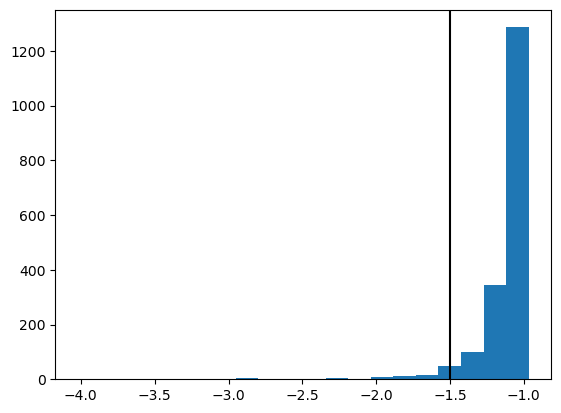

In [8]:
plt.hist(clf_LOF.negative_outlier_factor_, bins=20)
plt.axvline(np.min(clf_LOF.negative_outlier_factor_[np.where(y_pred==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

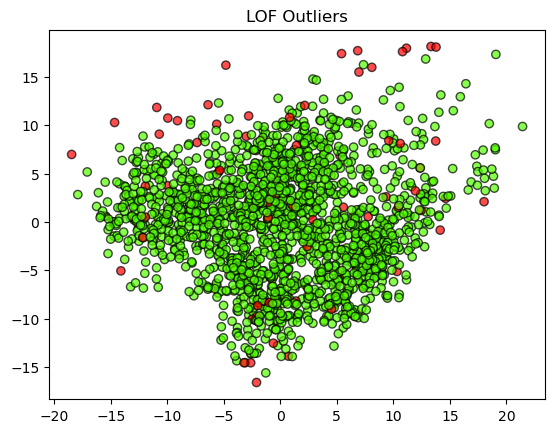

In [9]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

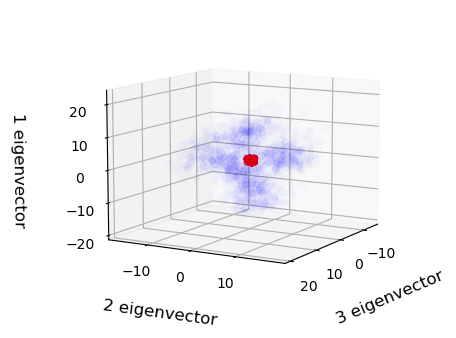

In [10]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 2]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 0]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers[:, 2]
y_vals = y_outliers[:, 1]
z_vals = y_outliers[:, 0]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

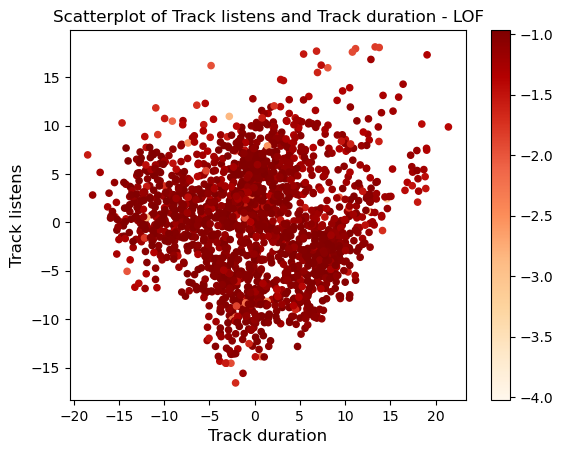

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, c = clf_LOF.negative_outlier_factor_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - LOF")

plt.colorbar()
plt.show()

In [12]:
# list with indexes and scores only for outliers --> np.where(y_pred==-1)
outlier_All_indexes_LOF = list(np.where(y_pred==-1)[0])
outlier_indexes = np.where(y_pred==-1)[0]
outlier_scores = clf_LOF.negative_outlier_factor_[outlier_indexes]

outlier_factor_list = []
for i in range(0,len(outlier_scores)):
    outlier_factor_list.append((outlier_indexes[i], outlier_scores[i]))
print(len(outlier_factor_list))

#We sort in ascending order with respect to LOF factor
def outlier_score(elem):
    return elem[1]
outlier_factor_list = sorted(outlier_factor_list, key=outlier_score)
outlier_factor_list[:10]

69


[(942, -4.020853779608738),
 (382, -3.161526814169341),
 (589, -2.9170910101817205),
 (1704, -2.8497052253615296),
 (1296, -2.8067705964914067),
 (1556, -2.551122113166343),
 (1496, -2.540090335003268),
 (361, -2.4930684706819983),
 (223, -2.354280239304682),
 (324, -2.2461963870350896)]

top 1% outliers

In [13]:
top1perc = int(float(len(train))*0.01)
top1perc

top_outliers_LOF = outlier_factor_list[:top1perc]
print(len(top_outliers_LOF))

indexes_list = [i[0] for i in top_outliers_LOF] #retrieve indexes of outliers
df_LOF_outliers = df_train.iloc[indexes_list]
df_LOF_outliers

18


,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
942,1,0,0,0,0,-0.015039,0.415854,-0.063106,-0.418081,-0.891494,...,-0.550847,2.039581,0,1,0,0,0,0,0,0
382,0,1,0,0,0,-0.050573,-0.731007,-0.063106,1.957812,-1.003460,...,8.823840,7.182804,0,1,0,0,0,0,0,0
589,0,1,1,1,0,-0.017032,-0.148176,-0.063106,0.366996,-1.029074,...,9.896848,7.541630,0,1,0,0,0,0,0,0
1704,1,1,1,0,1,1.982601,0.171441,24.081691,3.445327,1.768578,...,0.611723,-1.015228,0,0,0,1,0,0,0,0
1296,1,1,1,0,1,-0.024291,0.566262,-0.063106,-0.727980,0.721379,...,0.144202,-0.298906,0,0,1,0,0,0,0,0
1556,0,1,1,0,1,24.813411,0.209043,-0.063106,0.986795,0.836939,...,-0.902647,0.437972,0,0,0,1,0,0,0,0
1496,1,1,1,0,1,-19.147733,-0.599400,-0.063106,-0.128842,0.601504,...,1.883149,-1.335059,0,0,0,1,0,0,0,0
361,1,1,1,1,0,-0.024181,0.566262,-0.063106,-0.583361,0.553865,...,-0.090374,-0.267882,0,0,1,0,0,0,0,0
223,1,0,0,1,1,-0.024500,0.509859,-0.063106,-0.583361,0.401958,...,-0.719387,0.957737,0,0,0,0,1,0,0,0
324,1,0,1,0,0,-0.000284,0.603864,-0.063106,-0.748640,0.582265,...,-0.228991,0.532927,0,0,0,0,1,0,0,0


In [14]:
#retrieve track id of outliers
outliers_track_id = list(df_LOF_outliers.index)
outliers_track_id[:10]
print(len(outliers_track_id))

top_outliers_lof_track_id = []

for i, val in top_outliers_LOF:
    top_outliers_lof_track_id.append((df_train.iloc[i].name, val))
print(len(top_outliers_lof_track_id))

print("Track id with LOF score of outlierness")
top_outliers_lof_track_id


18
18
Track id with LOF score of outlierness


[(942, -4.020853779608738),
 (382, -3.161526814169341),
 (589, -2.9170910101817205),
 (1704, -2.8497052253615296),
 (1296, -2.8067705964914067),
 (1556, -2.551122113166343),
 (1496, -2.540090335003268),
 (361, -2.4930684706819983),
 (223, -2.354280239304682),
 (324, -2.2461963870350896),
 (314, -2.2449021584185527),
 (1367, -2.2426256645130054),
 (1281, -2.2370997611651515),
 (1597, -2.2361392757262903),
 (315, -2.2313038130397733),
 (1480, -2.140614311817738),
 (42, -2.048759947513928),
 (0, -1.9933276590437559)]

DBSCAN

In [15]:
# Tuning eps,MinPts for DBSCAN --->  Studiamo la distanza media tra i noise points e i 10(per esempio) punti più vicini (6-NN) e il numero di cluster generati.

eps_to_test = list(range(5, 15, 1))
min_samples_to_test = list(range(5, 50, 5))
print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))
scaled_dataframe=pd.DataFrame(train,columns=df_train.columns)

from sklearn.neighbors import NearestNeighbors

def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 10).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

# Istanziamo i due dataframe che conterranno i risultati del grid search

# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

EPS: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
MIN_SAMPLES: [5, 10, 15, 20, 25, 30, 35, 40, 45]


In [16]:
# Lets' try grid search

iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled_dataframe, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps =   5 and min_samples =   5 | 11.064    0
  2 | Tested with eps =   5 and min_samples =  10 | 11.064    0
  3 | Tested with eps =   5 and min_samples =  15 | 11.064    0
  4 | Tested with eps =   5 and min_samples =  20 | 11.064    0
  5 | Tested with eps =   5 and min_samples =  25 | 11.064    0
  6 | Tested with eps =   5 and min_samples =  30 | 11.064    0
  7 | Tested with eps =   5 and min_samples =  35 | 11.064    0
  8 | Tested with eps =   5 and min_samples =  40 | 11.064    0
  9 | Tested with eps =   5 and min_samples =  45 | 11.064    0
 10 | Tested with eps =   6 and min_samples =   5 |  11.1    2
 11 | Tested with eps =   6 and min_samples =  10 | 11.064    0
 12 | Tested with eps =   6 and min_samples =  15 | 11.064    0
 13 | Tested with eps =   6 and min_samples =  20 | 11.064    0
 14 | Tested with eps =   6 and min_s

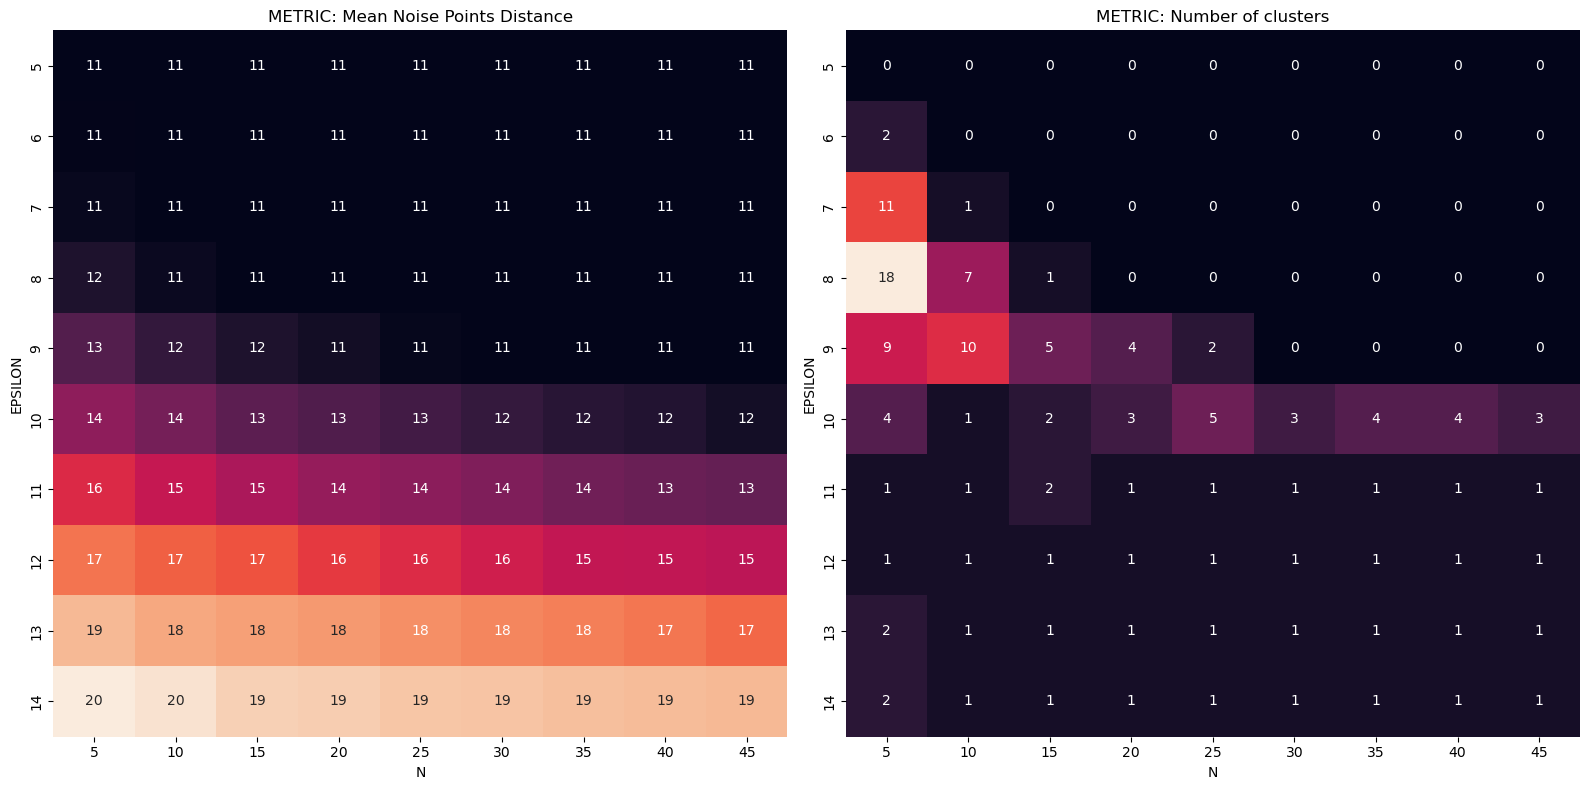

In [17]:
# Mostriamo i risultati del grid search appena eseguito per cercare la "miglior" combinazione di iperparametri:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [18]:
# Istantiating with eps = 9 and min_samples = 5 (best model)
best_dbscan_model = DBSCAN(eps = 10, min_samples = 5)

# Fitting
best_dbscan_model.fit(scaled_dataframe)

# Extracting labels
scaled_dataframe["LABEL"] = best_dbscan_model.labels_

In [19]:

np.unique(best_dbscan_model.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3], dtype=int64),
 array([ 690, 1093,    4,   23,   18], dtype=int64))

In [20]:
dbscan_indexes = list(df_train.index)
scaled_dbscan_with_track_id = scaled_dataframe.copy()
scaled_dbscan_with_track_id['track_id'] = dbscan_indexes
scaled_dbscan_with_track_id = scaled_dbscan_with_track_id.set_index('track_id')
scaled_dbscan_with_track_id[scaled_dbscan_with_track_id['LABEL'] == -1]


,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,LABEL
track_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,1.0,0.0,1.0,0.018034,0.603864,-0.063106,-0.769300,0.553248,...,-3.035005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1
1,1.0,0.0,1.0,1.0,1.0,0.013950,0.603864,-0.063106,-0.769300,0.770118,...,0.434538,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1
4,1.0,0.0,1.0,0.0,1.0,0.015921,0.603864,-0.063106,-0.769300,0.286970,...,-0.532241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
5,1.0,0.0,1.0,1.0,1.0,0.015924,0.603864,-0.063106,-0.769300,1.240973,...,-1.964541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,1.0,0.0,0.0,1.0,1.0,0.011850,0.603864,-0.063106,-0.748640,0.029338,...,-0.135864,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,1.0,1.0,0.0,1.0,0.0,-0.004257,0.397053,-0.063106,-0.438741,1.545585,...,-0.281466,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1
1824,1.0,1.0,1.0,0.0,0.0,-0.016770,0.603864,-0.063106,-0.748640,-0.237333,...,-0.504115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
1825,1.0,1.0,1.0,1.0,0.0,-0.025751,0.622665,-0.063106,-0.748640,-0.806583,...,-0.454243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1


In [21]:
#retrieve track id of outliers
outlier_All_indexes_DBSCAN = list(scaled_dbscan_with_track_id[scaled_dbscan_with_track_id['LABEL'] == -1].index)
outliers_dbscan = list(scaled_dbscan_with_track_id[scaled_dbscan_with_track_id['LABEL'] == -1].index)
print(len(outliers_dbscan))
outliers_dbscan[:10]

690


[0, 1, 4, 5, 7, 8, 10, 11, 13, 17]

In [22]:
# open file
with open('outliers_dbscan(track_id).txt', 'w+') as f:
      
    # write elements of list
    for items in outliers_dbscan:
        f.write('%s\n' %items)
      
    print("File written successfully")
    
# close the file
f.close()

File written successfully


# Distance-based approach

KNN(k=5)

In [23]:
clf_KNN = KNN(n_neighbors=5)
clf_KNN.fit(train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [24]:
outliers_KNN = clf_KNN.predict(train)
np.unique(outliers_KNN, return_counts=True)

(array([0, 1]), array([1664,  164], dtype=int64))

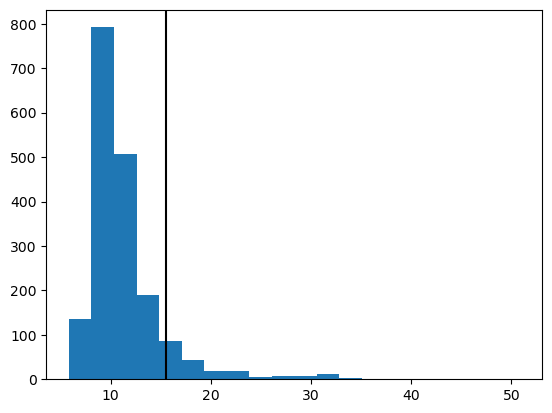

In [25]:
plt.hist(clf_KNN.decision_scores_, bins=20)
plt.axvline(np.min(clf_KNN.decision_scores_[np.where(outliers_KNN==1)]), c='k')
plt.show()

In [26]:
outlier_All_indexes_knn=list(np.where(outliers_KNN==1)[0])
outlier_indexes_knn = np.where(outliers_KNN==1)[0]
outlier_scores_knn = clf_KNN.decision_scores_[outlier_indexes_knn]
y_outliers_knn = train[outliers_KNN==1]


Text(0.5, 1.0, 'LOF Outliers')

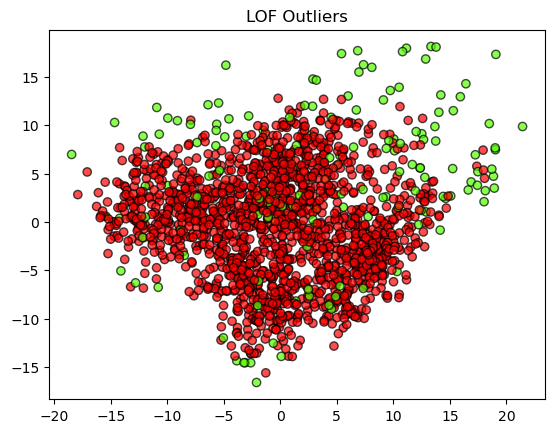

In [27]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers_KNN, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")


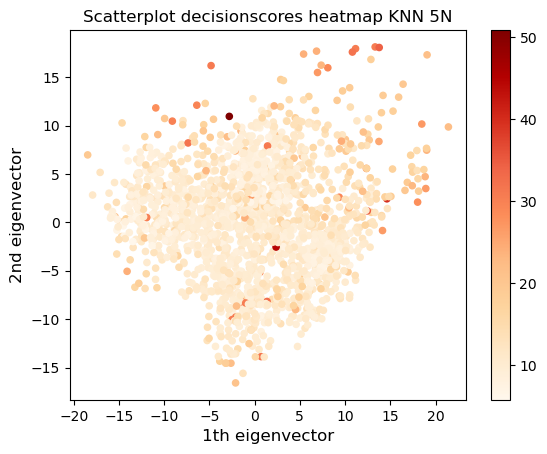

In [28]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, c = clf_KNN.decision_scores_, cmap='OrRd')

plt.xlabel('1th eigenvector'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('2nd eigenvector'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot decisionscores heatmap KNN 5N")

plt.colorbar()
plt.show()

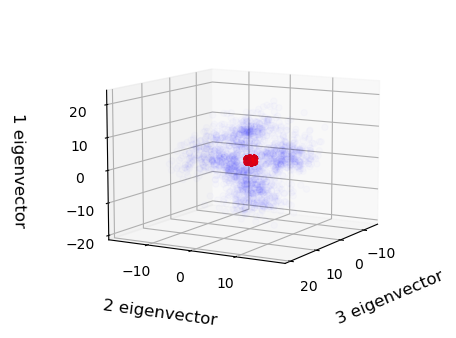

In [29]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 2]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 0]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers_knn[:, 2]
y_vals = y_outliers_knn[:, 1]
z_vals = y_outliers_knn[:, 0]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

In [30]:
#top 1% outliers
outlier_knn_list = []

for i in range(0,len(outlier_scores_knn)):
    outlier_knn_list.append((outlier_indexes_knn[i], outlier_scores_knn[i]))
    
outlier_knn_list[:10]
outlier_knn_list = sorted(outlier_knn_list, key=outlier_score, reverse = True)
top_outliers_knn = outlier_knn_list[:top1perc]
indexes_list_knn = [i[0] for i in top_outliers_knn] #retrieve index of outliers

df_knn_outliers = df_train.iloc[indexes_list_knn]
df_knn_outliers

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
1704,1,1,1,0,1,1.982601,0.171441,24.081691,3.445327,1.768578,...,0.611723,-1.015228,0,0,0,1,0,0,0,0
942,1,0,0,0,0,-0.015039,0.415854,-0.063106,-0.418081,-0.891494,...,-0.550847,2.039581,0,1,0,0,0,0,0,0
382,0,1,0,0,0,-0.050573,-0.731007,-0.063106,1.957812,-1.003460,...,8.823840,7.182804,0,1,0,0,0,0,0,0
589,0,1,1,1,0,-0.017032,-0.148176,-0.063106,0.366996,-1.029074,...,9.896848,7.541630,0,1,0,0,0,0,0,0
309,0,1,1,1,1,0.390129,-3.513556,7.985159,5.139442,0.856096,...,-0.739962,1.017571,0,0,0,1,0,0,0,0
361,1,1,1,1,0,-0.024181,0.566262,-0.063106,-0.583361,0.553865,...,-0.090374,-0.267882,0,0,1,0,0,0,0,0
1496,1,1,1,0,1,-19.147733,-0.599400,-0.063106,-0.128842,0.601504,...,1.883149,-1.335059,0,0,0,1,0,0,0,0
311,0,1,0,1,1,1.975369,-5.186846,16.033425,5.325382,-0.543338,...,-0.824514,0.512921,0,0,0,1,0,0,0,0
1556,0,1,1,0,1,24.813411,0.209043,-0.063106,0.986795,0.836939,...,-0.902647,0.437972,0,0,0,1,0,0,0,0
1702,1,0,0,0,1,1.110427,-1.727461,-8.111372,1.751212,1.377952,...,3.338934,-2.421469,0,0,0,1,0,0,0,0


In [31]:
#retrieve track id of outliers
outliers_track_id_knn = list(df_knn_outliers.index)
outliers_track_id_knn[:10]
len(outliers_track_id_knn)

18

In [32]:
top_outliers_knn_track_id = []

for i, val in top_outliers_knn:
    top_outliers_knn_track_id.append((df_train.iloc[i].name, val))

print("Track id with knn score of outlierness",len(top_outliers_knn_track_id))
top_outliers_knn_track_id[:10]

Track id with knn score of outlierness 18


[(1704, 50.83181114237847),
 (942, 44.58059219561508),
 (382, 39.75483548206206),
 (589, 34.59655911111859),
 (309, 34.36371356716168),
 (361, 32.81188599125438),
 (1496, 32.010558776728544),
 (311, 31.922485200504354),
 (1556, 31.100638186999863),
 (1702, 30.992911473104233)]

KNN(K=10)

In [33]:
clf_KNN2 = KNN(n_neighbors=10)
clf_KNN2.fit(train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=10, p=2,
  radius=1.0)

In [34]:

outliers_KNN2 = clf_KNN2.predict(train)
np.unique(outliers_KNN2, return_counts=True)

(array([0, 1]), array([1652,  176], dtype=int64))

In [35]:
outlier_All_indexes_knn2=list(np.where(outliers_KNN2==1)[0])
outlier_indexes_knn2 = np.where(outliers_KNN2==1)[0]
outlier_scores_knn2 = clf_KNN2.decision_scores_[outlier_indexes_knn2]
y_outliers_knn2 = train[outliers_KNN==1]

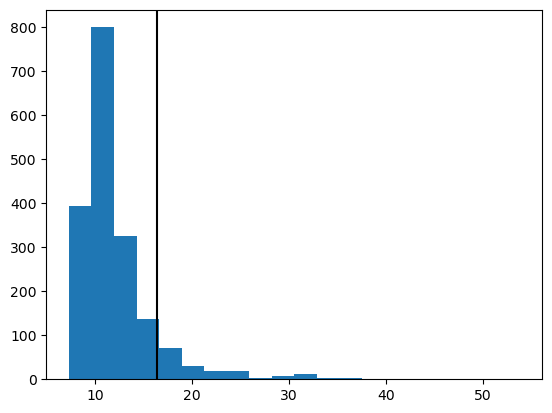

In [36]:
plt.hist(clf_KNN2.decision_scores_, bins=20)
plt.axvline(np.min(clf_KNN2.decision_scores_[np.where(outliers_KNN2==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

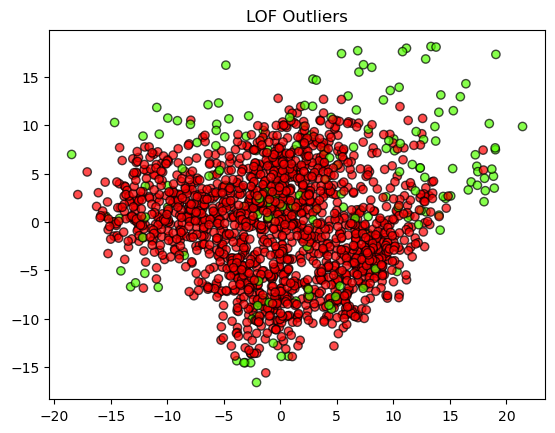

In [37]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers_KNN2, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

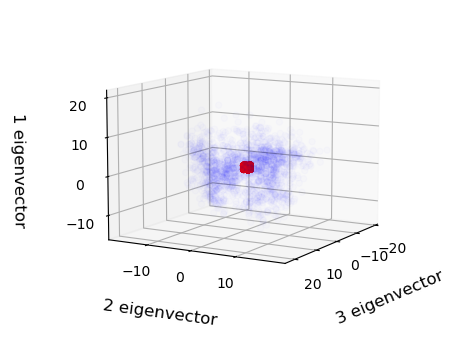

In [38]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 0]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 2]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers_knn2[:, 0]
y_vals = y_outliers_knn2[:, 1]
z_vals = y_outliers_knn2[:, 2]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

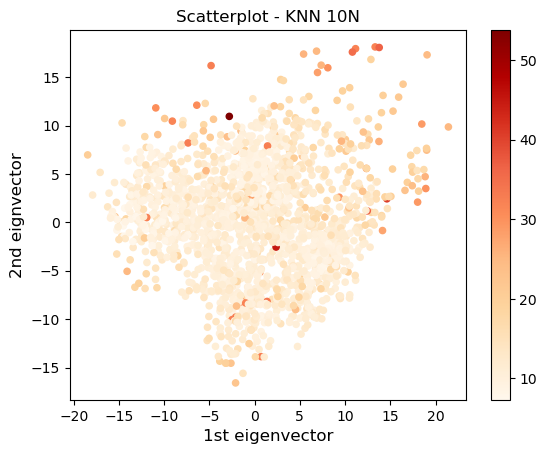

In [39]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, c = clf_KNN2.decision_scores_, cmap='OrRd')

plt.xlabel('1st eigenvector'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('2nd eignvector'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot - KNN 10N")

plt.colorbar()
plt.show()

In [40]:

outlier_knn_list2 = []

for i in range(0,len(outlier_scores_knn2)):
    outlier_knn_list2.append((outlier_indexes_knn2[i], outlier_scores_knn2[i]))
    
outlier_knn_list2[:10]

[(0, 24.990897957770613),
 (8, 22.44331533355152),
 (32, 18.186779820063187),
 (33, 30.025711627259806),
 (35, 29.679381096107914),
 (40, 19.969653778771637),
 (42, 29.92157461031968),
 (53, 18.249134933469787),
 (59, 18.713928951978378),
 (93, 19.11423713738477)]

In [41]:
#We sort in ascending order with respect to LOF factor
def outlier_score(elem):
    return elem[1]

outlier_knn_list2 = sorted(outlier_knn_list2, key=outlier_score, reverse = True)
outlier_knn_list2[:10]

[(1704, 53.76671566852968),
 (942, 44.89252785880992),
 (382, 40.844816674014744),
 (589, 36.58203149443201),
 (309, 36.580997223707776),
 (311, 35.19423171668002),
 (361, 33.68777097486048),
 (314, 32.92644072358049),
 (1496, 32.84435107587827),
 (1367, 32.79057502282817)]

In [42]:
# top 1% outliers
top_outliers_knn2 = outlier_knn_list2[:top1perc]
indexes_list_knn2 = [i[0] for i in top_outliers_knn2] #retrieve index of outliers
df_knn_outliers2 = df_train.iloc[indexes_list_knn2]
df_knn_outliers2

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
1704,1,1,1,0,1,1.982601,0.171441,24.081691,3.445327,1.768578,...,0.611723,-1.015228,0,0,0,1,0,0,0,0
942,1,0,0,0,0,-0.015039,0.415854,-0.063106,-0.418081,-0.891494,...,-0.550847,2.039581,0,1,0,0,0,0,0,0
382,0,1,0,0,0,-0.050573,-0.731007,-0.063106,1.957812,-1.003460,...,8.823840,7.182804,0,1,0,0,0,0,0,0
589,0,1,1,1,0,-0.017032,-0.148176,-0.063106,0.366996,-1.029074,...,9.896848,7.541630,0,1,0,0,0,0,0,0
309,0,1,1,1,1,0.390129,-3.513556,7.985159,5.139442,0.856096,...,-0.739962,1.017571,0,0,0,1,0,0,0,0
311,0,1,0,1,1,1.975369,-5.186846,16.033425,5.325382,-0.543338,...,-0.824514,0.512921,0,0,0,1,0,0,0,0
361,1,1,1,1,0,-0.024181,0.566262,-0.063106,-0.583361,0.553865,...,-0.090374,-0.267882,0,0,1,0,0,0,0,0
314,1,0,0,0,0,0.000113,0.622665,-0.063106,-0.769300,0.688109,...,-0.079467,0.385982,0,0,0,0,0,1,0,0
1496,1,1,1,0,1,-19.147733,-0.599400,-0.063106,-0.128842,0.601504,...,1.883149,-1.335059,0,0,0,1,0,0,0,0
1367,1,0,0,1,0,0.004935,0.603864,-0.063106,-0.769300,-0.516880,...,1.806507,-1.550232,0,0,0,0,1,0,0,0


In [43]:

#retrieve track id of outliers
outliers_track_id_knn2 = list(df_knn_outliers2.index)
outliers_track_id_knn2[:10]
len(outliers_track_id_knn2)

18

In [44]:

top_outliers_knn_track_id2 = []

for i, val in top_outliers_knn2:
    top_outliers_knn_track_id2.append((df_train.iloc[i].name, val))

print("Track id with knn score of outlierness")
top_outliers_knn_track_id2[:10]

Track id with knn score of outlierness


[(1704, 53.76671566852968),
 (942, 44.89252785880992),
 (382, 40.844816674014744),
 (589, 36.58203149443201),
 (309, 36.580997223707776),
 (311, 35.19423171668002),
 (361, 33.68777097486048),
 (314, 32.92644072358049),
 (1496, 32.84435107587827),
 (1367, 32.79057502282817)]

# Angle-based approach

ABOD(n=5)

In [45]:
clf_ABOD = ABOD()
clf_ABOD.fit(train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [46]:
outliers_ABOD = clf_ABOD.predict(train)
np.unique(outliers_ABOD, return_counts=True)

(array([0, 1]), array([1609,  219], dtype=int64))

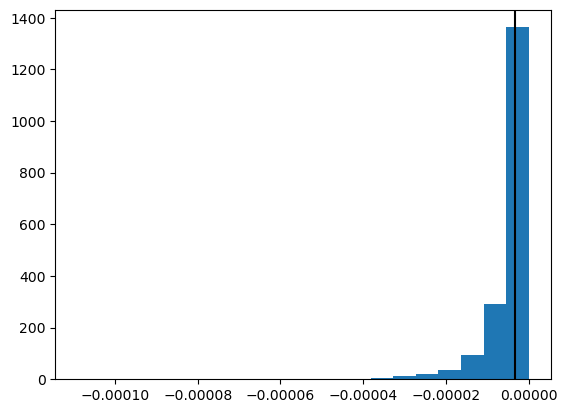

In [47]:
outlier_All_indexes_abod=list(np.where(outliers_ABOD==1)[0])
outlier_indexes_abod = np.where(outliers_ABOD==1)[0]
outlier_scores_abod = clf_ABOD.decision_scores_[outlier_indexes_abod]
y_outliers_ABOD = train[outliers_ABOD==1]

plt.hist(clf_ABOD.decision_scores_, bins=20)
plt.axvline(np.min(clf_ABOD.decision_scores_[np.where(outliers_ABOD==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

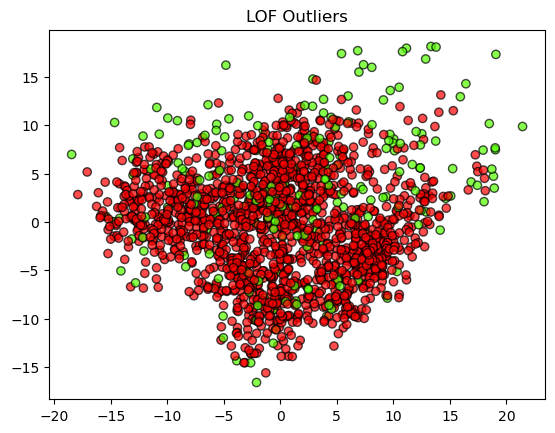

In [48]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers_ABOD, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

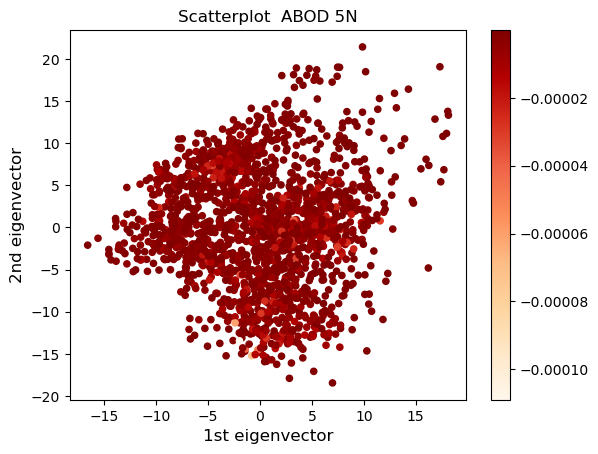

In [49]:
plt.scatter(X_pca[:, 1], X_pca[:, 0], s=20, c = clf_ABOD.decision_scores_, cmap='OrRd')

plt.xlabel('1st eigenvector'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('2nd eigenvector'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot  ABOD 5N")

plt.colorbar()
plt.show()

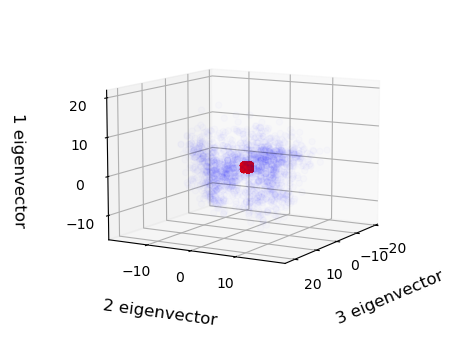

In [50]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 0]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 2]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers_ABOD[:, 0]
y_vals = y_outliers_ABOD[:, 1]
z_vals = y_outliers_ABOD[:, 2]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

In [51]:
outlier_abod_list = []

for i in range(0,len(outlier_scores_abod)):
    outlier_abod_list.append((outlier_indexes_abod[i], outlier_scores_abod[i]))
    
outlier_abod_list = sorted(outlier_abod_list, key=outlier_score, reverse = True)
outlier_abod_list[:10]

[(942, -2.6786123513972596e-11),
 (1704, -1.1515494212973033e-09),
 (382, -4.469202223374248e-09),
 (1296, -4.7213336546857765e-09),
 (1702, -5.365526929228527e-09),
 (223, -5.6341109336875425e-09),
 (1281, -8.411272267416276e-09),
 (1766, -1.2606344992812957e-08),
 (42, -1.3445727989791085e-08),
 (8, -1.4233733078171145e-08)]

In [52]:
# top 1% outliers
top_outliers_ABOD = outlier_abod_list[:top1perc]
indexes_list_ABOD = [i[0] for i in top_outliers_ABOD] #retrieve index of outliers
df_ABOD_outliers = df_train.iloc[indexes_list_ABOD]
df_ABOD_outliers

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
942,1,0,0,0,0,-0.015039,0.415854,-0.063106,-0.418081,-0.891494,...,-0.550847,2.039581,0,1,0,0,0,0,0,0
1704,1,1,1,0,1,1.982601,0.171441,24.081691,3.445327,1.768578,...,0.611723,-1.015228,0,0,0,1,0,0,0,0
382,0,1,0,0,0,-0.050573,-0.731007,-0.063106,1.957812,-1.003460,...,8.823840,7.182804,0,1,0,0,0,0,0,0
1296,1,1,1,0,1,-0.024291,0.566262,-0.063106,-0.727980,0.721379,...,0.144202,-0.298906,0,0,1,0,0,0,0,0
1702,1,0,0,0,1,1.110427,-1.727461,-8.111372,1.751212,1.377952,...,3.338934,-2.421469,0,0,0,1,0,0,0,0
223,1,0,0,1,1,-0.024500,0.509859,-0.063106,-0.583361,0.401958,...,-0.719387,0.957737,0,0,0,0,1,0,0,0
1281,1,1,1,1,1,-0.148928,0.002232,-0.063106,-0.190822,0.111646,...,1.598356,-1.569349,1,0,0,0,0,0,0,0
1766,0,1,0,0,1,11.108706,-0.900216,5.302404,3.404007,0.543482,...,1.835939,-2.074678,0,0,0,1,0,0,0,0
42,1,1,0,0,1,0.279885,-0.787410,-0.063106,0.552936,0.417530,...,-0.522506,1.663952,0,0,0,1,0,0,0,0
8,1,1,1,0,1,0.008405,0.585063,-0.063106,-0.748640,-0.126199,...,1.794703,-1.480839,0,1,0,0,0,0,0,0


In [53]:
#retrieve track id of outliers
outliers_track_id_abod = list(df_ABOD_outliers.index)

top_outliers_ABOD_track_id = []

for i, val in top_outliers_ABOD:
    top_outliers_ABOD_track_id.append((df_train.iloc[i].name, val))

print("Track id with ABOD score of outlierness")
top_outliers_ABOD_track_id[:10]


Track id with ABOD score of outlierness


[(942, -2.6786123513972596e-11),
 (1704, -1.1515494212973033e-09),
 (382, -4.469202223374248e-09),
 (1296, -4.7213336546857765e-09),
 (1702, -5.365526929228527e-09),
 (223, -5.6341109336875425e-09),
 (1281, -8.411272267416276e-09),
 (1766, -1.2606344992812957e-08),
 (42, -1.3445727989791085e-08),
 (8, -1.4233733078171145e-08)]

ABOD(n=10)

In [54]:
clf_ABOD_2 = ABOD(n_neighbors=10)
clf_ABOD_2.fit(train)

ABOD(contamination=0.1, method='fast', n_neighbors=10)

In [55]:
outliers_ABOD_2 = clf_ABOD_2.predict(train)
np.unique(outliers_ABOD_2, return_counts=True)

(array([0, 1]), array([1641,  187], dtype=int64))

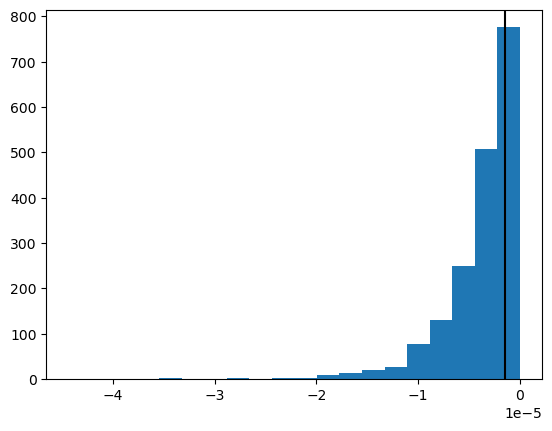

In [56]:
outlier_All_indexes_abod2=list(np.where(outliers_ABOD_2==1)[0])
outlier_indexes_abod2 = np.where(outliers_ABOD_2==1)[0]
outlier_scores_abod2 = clf_ABOD_2.decision_scores_[outlier_indexes_abod2]
y_outliers_ABOD2 = train[outliers_ABOD_2==1]

plt.hist(clf_ABOD_2.decision_scores_, bins=20)
plt.axvline(np.min(clf_ABOD_2.decision_scores_[np.where(outliers_ABOD_2==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

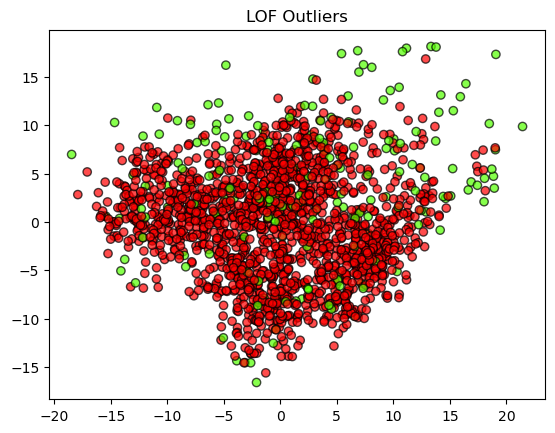

In [57]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers_ABOD_2, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

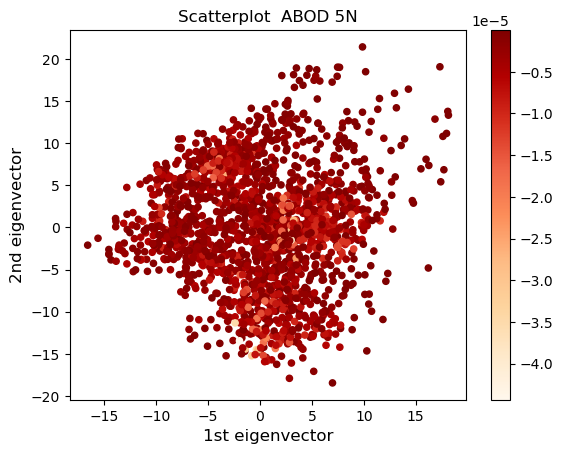

In [58]:
plt.scatter(X_pca[:, 1], X_pca[:, 0], s=20, c = clf_ABOD_2.decision_scores_, cmap='OrRd')

plt.xlabel('1st eigenvector'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('2nd eigenvector'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot  ABOD 5N")

plt.colorbar()
plt.show()

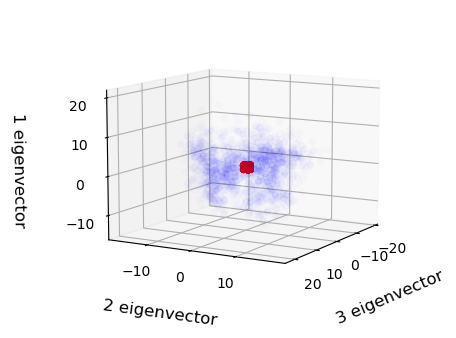

In [59]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 0]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 2]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers_ABOD2[:, 0]
y_vals = y_outliers_ABOD2[:, 1]
z_vals = y_outliers_ABOD2[:, 2]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

In [60]:
outlier_abod_list2 = []

for i in range(0,len(outlier_scores_abod2)):
    outlier_abod_list2.append((outlier_indexes_abod2[i], outlier_scores_abod2[i]))
outlier_abod_list2 = sorted(outlier_abod_list2, key=outlier_score, reverse = True)

In [61]:
#top 1% outliers

top_outliers_ABOD2 = outlier_abod_list2[:top1perc]
indexes_list_ABOD2 = [i[0] for i in top_outliers_ABOD2] #retrieve index of outliers
df_ABOD_outliers2 = df_train.iloc[indexes_list_ABOD2]
df_ABOD_outliers2

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
942,1,0,0,0,0,-0.015039,0.415854,-0.063106,-0.418081,-0.891494,...,-0.550847,2.039581,0,1,0,0,0,0,0,0
1704,1,1,1,0,1,1.982601,0.171441,24.081691,3.445327,1.768578,...,0.611723,-1.015228,0,0,0,1,0,0,0,0
382,0,1,0,0,0,-0.050573,-0.731007,-0.063106,1.957812,-1.003460,...,8.823840,7.182804,0,1,0,0,0,0,0,0
1296,1,1,1,0,1,-0.024291,0.566262,-0.063106,-0.727980,0.721379,...,0.144202,-0.298906,0,0,1,0,0,0,0,0
1702,1,0,0,0,1,1.110427,-1.727461,-8.111372,1.751212,1.377952,...,3.338934,-2.421469,0,0,0,1,0,0,0,0
1496,1,1,1,0,1,-19.147733,-0.599400,-0.063106,-0.128842,0.601504,...,1.883149,-1.335059,0,0,0,1,0,0,0,0
1281,1,1,1,1,1,-0.148928,0.002232,-0.063106,-0.190822,0.111646,...,1.598356,-1.569349,1,0,0,0,0,0,0,0
223,1,0,0,1,1,-0.024500,0.509859,-0.063106,-0.583361,0.401958,...,-0.719387,0.957737,0,0,0,0,1,0,0,0
1556,0,1,1,0,1,24.813411,0.209043,-0.063106,0.986795,0.836939,...,-0.902647,0.437972,0,0,0,1,0,0,0,0
361,1,1,1,1,0,-0.024181,0.566262,-0.063106,-0.583361,0.553865,...,-0.090374,-0.267882,0,0,1,0,0,0,0,0


In [62]:
#retrieve track id of outliers
outliers_track_id_abod2 = list(df_ABOD_outliers2.index)

top_outliers_ABOD2_track_id = []

for i, val in top_outliers_ABOD2:
    top_outliers_ABOD2_track_id.append((df_train.iloc[i].name, val))

print("Track id with ABOD2 score of outlierness")
top_outliers_ABOD2_track_id[:10]

Track id with ABOD2 score of outlierness


[(942, -2.760046106686206e-11),
 (1704, -7.040193662289323e-10),
 (382, -3.493269041265851e-09),
 (1296, -8.443368960177188e-09),
 (1702, -1.1074756079409813e-08),
 (1496, -1.2356077061838229e-08),
 (1281, -1.4673284844913472e-08),
 (223, -1.5377383935368216e-08),
 (1556, -1.6957051457421876e-08),
 (361, -1.8181210945258802e-08)]

In [63]:
len(top_outliers_ABOD2_track_id)

18

# Model-based approach

ISOLATION FOREST

In [64]:
from sklearn.ensemble import IsolationForest
clf_if = IsolationForest(random_state=0)
clf_if.fit(train)

IsolationForest(random_state=0)

In [65]:
outliers_if = clf_if.predict(train)
np.unique(outliers_if, return_counts=True)


(array([-1,  1]), array([  54, 1774], dtype=int64))

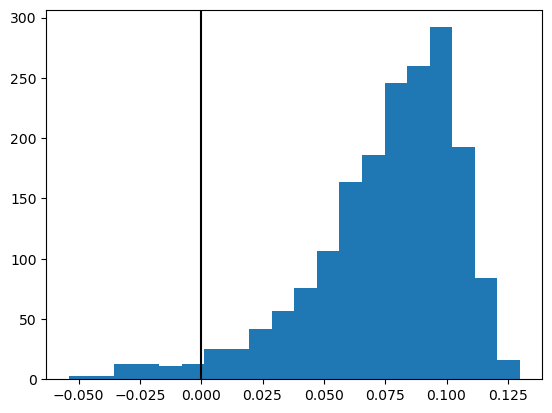

In [66]:
plt.hist(clf_if.decision_function(train), bins=20)
plt.axvline(np.min(clf_if.decision_function(train)[np.where(outliers_if==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

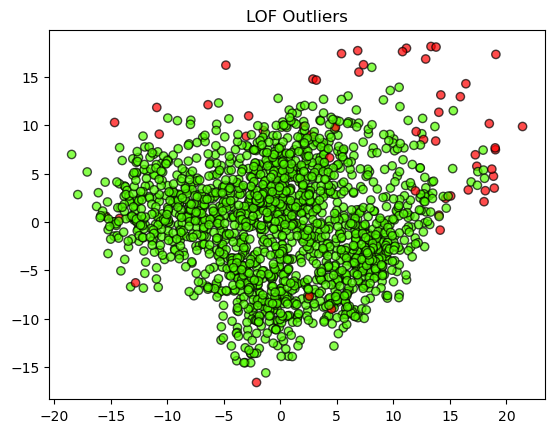

In [67]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers_if, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

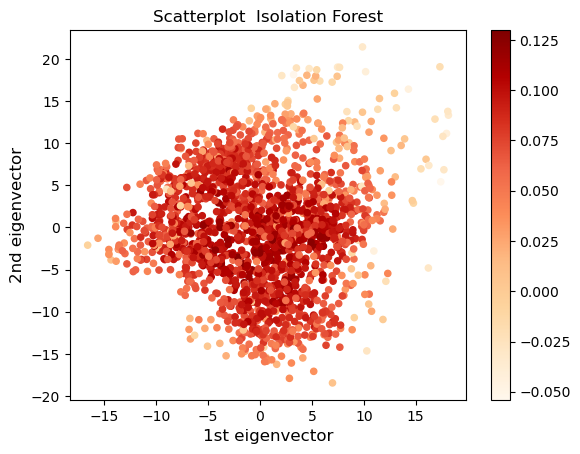

In [68]:
plt.scatter(X_pca[:, 1], X_pca[:, 0], s=20, c =clf_if.decision_function(train), cmap='OrRd')

plt.xlabel('1st eigenvector'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('2nd eigenvector'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot  Isolation Forest")

plt.colorbar()
plt.show()

In [69]:
outlier_All_indexes_IF=list(np.where(outliers_if == -1)[0])
y_outliers_if = train[outliers_if==1]
outlier_indexes_if = np.where(outliers_if == -1)[0]
indexes_list_if = list(outlier_indexes_if)  #retrieve index of outliers

outlier_scores_if=clf_if.decision_function(train)

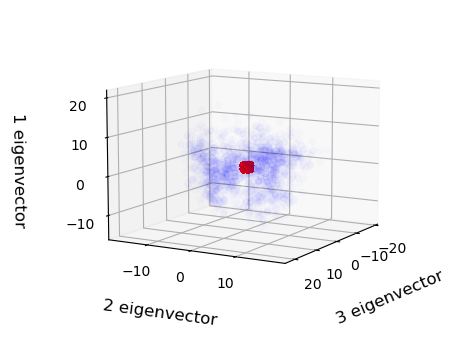

In [70]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 0]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 2]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers_if[:, 0]
y_vals = y_outliers_if[:, 1]
z_vals = y_outliers_if[:, 2]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

# Comparison

Top 10 of LOF

In [71]:
from tabulate import tabulate

headers = ["Track_id", "Score"]
print("Latex table\n")
print(tabulate(top_outliers_lof_track_id[:10], headers, colalign=("left","left"), tablefmt = 'latex'))
print()
print('-----------------------------')
print()
print("Normal table\n")
print(tabulate(top_outliers_lof_track_id[:10], headers, colalign=("left","left"), tablefmt = 'simple'))

Latex table

\begin{tabular}{ll}
\hline
 Track\_id   & Score    \\
\hline
 942        & -4.02085 \\
 382        & -3.16153 \\
 589        & -2.91709 \\
 1704       & -2.84971 \\
 1296       & -2.80677 \\
 1556       & -2.55112 \\
 1496       & -2.54009 \\
 361        & -2.49307 \\
 223        & -2.35428 \\
 324        & -2.2462  \\
\hline
\end{tabular}

-----------------------------

Normal table

Track_id    Score
----------  --------
942         -4.02085
382         -3.16153
589         -2.91709
1704        -2.84971
1296        -2.80677
1556        -2.55112
1496        -2.54009
361         -2.49307
223         -2.35428
324         -2.2462


top 10 of KNN

In [72]:
print("Latex table\n")
print(tabulate(top_outliers_knn_track_id[:10], headers, colalign=("left","left"), tablefmt = 'latex'))
print()
print('-----------------------------')
print()
print("Normal table\n")
print(tabulate(top_outliers_knn_track_id[:10], headers, colalign=("left","left"), tablefmt = 'simple'))

Latex table

\begin{tabular}{ll}
\hline
 Track\_id   & Score   \\
\hline
 1704       & 50.8318 \\
 942        & 44.5806 \\
 382        & 39.7548 \\
 589        & 34.5966 \\
 309        & 34.3637 \\
 361        & 32.8119 \\
 1496       & 32.0106 \\
 311        & 31.9225 \\
 1556       & 31.1006 \\
 1702       & 30.9929 \\
\hline
\end{tabular}

-----------------------------

Normal table

Track_id    Score
----------  -------
1704        50.8318
942         44.5806
382         39.7548
589         34.5966
309         34.3637
361         32.8119
1496        32.0106
311         31.9225
1556        31.1006
1702        30.9929


Top 10 of KNN2

In [73]:
print("Latex table\n")
print(tabulate(top_outliers_knn_track_id2[:10], headers, colalign=("left","left"), tablefmt = 'latex'))
print()
print('-----------------------------')
print()
print("Normal table\n")
print(tabulate(top_outliers_knn_track_id2[:10], headers, colalign=("left","left"), tablefmt = 'simple'))

Latex table

\begin{tabular}{ll}
\hline
 Track\_id   & Score   \\
\hline
 1704       & 53.7667 \\
 942        & 44.8925 \\
 382        & 40.8448 \\
 589        & 36.582  \\
 309        & 36.581  \\
 311        & 35.1942 \\
 361        & 33.6878 \\
 314        & 32.9264 \\
 1496       & 32.8444 \\
 1367       & 32.7906 \\
\hline
\end{tabular}

-----------------------------

Normal table

Track_id    Score
----------  -------
1704        53.7667
942         44.8925
382         40.8448
589         36.582
309         36.581
311         35.1942
361         33.6878
314         32.9264
1496        32.8444
1367        32.7906


Top 10 of ABOD

In [74]:
print("Latex table\n")
print(tabulate(top_outliers_ABOD_track_id[:10], headers, colalign=("left","left"), tablefmt = 'latex'))
print()
print('-----------------------------')
print()
print("Normal table\n")
print(tabulate(top_outliers_ABOD_track_id[:10], headers, colalign=("left","left"), tablefmt = 'simple'))

Latex table

\begin{tabular}{ll}
\hline
 Track\_id   & Score        \\
\hline
 942        & -2.67861e-11 \\
 1704       & -1.15155e-09 \\
 382        & -4.4692e-09  \\
 1296       & -4.72133e-09 \\
 1702       & -5.36553e-09 \\
 223        & -5.63411e-09 \\
 1281       & -8.41127e-09 \\
 1766       & -1.26063e-08 \\
 42         & -1.34457e-08 \\
 8          & -1.42337e-08 \\
\hline
\end{tabular}

-----------------------------

Normal table

Track_id    Score
----------  ------------
942         -2.67861e-11
1704        -1.15155e-09
382         -4.4692e-09
1296        -4.72133e-09
1702        -5.36553e-09
223         -5.63411e-09
1281        -8.41127e-09
1766        -1.26063e-08
42          -1.34457e-08
8           -1.42337e-08


Top 10 of ABOD2

In [75]:
print("Latex table\n")
print(tabulate(top_outliers_ABOD2_track_id[:10], headers, colalign=("left","left"), tablefmt = 'latex'))
print()
print('-----------------------------')
print()
print("Normal table\n")
print(tabulate(top_outliers_ABOD2_track_id[:10], headers, colalign=("left","left"), tablefmt = 'simple'))

Latex table

\begin{tabular}{ll}
\hline
 Track\_id   & Score        \\
\hline
 942        & -2.76005e-11 \\
 1704       & -7.04019e-10 \\
 382        & -3.49327e-09 \\
 1296       & -8.44337e-09 \\
 1702       & -1.10748e-08 \\
 1496       & -1.23561e-08 \\
 1281       & -1.46733e-08 \\
 223        & -1.53774e-08 \\
 1556       & -1.69571e-08 \\
 361        & -1.81812e-08 \\
\hline
\end{tabular}

-----------------------------

Normal table

Track_id    Score
----------  ------------
942         -2.76005e-11
1704        -7.04019e-10
382         -3.49327e-09
1296        -8.44337e-09
1702        -1.10748e-08
1496        -1.23561e-08
1281        -1.46733e-08
223         -1.53774e-08
1556        -1.69571e-08
361         -1.81812e-08


Now we do the INTERSECTION of top 1%=18 of the data

In [76]:
set_LOF = set([i[0] for i in top_outliers_lof_track_id])
set_DBSCAN = set(outliers_dbscan)
set_KNN = set([i[0] for i in top_outliers_knn_track_id])
set_KNN2 = set([i[0] for i in top_outliers_knn_track_id2])
set_ABOD = set([i[0] for i in top_outliers_ABOD_track_id])
set_ABOD2 = set([i[0] for i in top_outliers_ABOD2_track_id])

sets = [set_LOF, set_DBSCAN, set_KNN, set_KNN2, set_ABOD, set_ABOD2]
sets_names = ['LOF', 'DBSCAN', 'KNN_5N', 'KNN_10N', 'ABOD_5N', 'ABOD_10N']

In [77]:
tab_intersection_top_1perc_outliers = []
headers_outliers = ['Methods', 'Intersection']
print("Intersections of top 1%\n")

for i in range(0, len(sets)):
    for j in range(i+1, len(sets)):
        methods = ' - '.join(map(str, (sets_names[i], sets_names[j])))
        intersection = len(sets[i].intersection(sets[j]))
        print("{0:20} {1}".format(methods, intersection))
        if intersection != 0:
            tab_intersection_top_1perc_outliers.append((methods, intersection))

Intersections of top 1%

LOF - DBSCAN         18
LOF - KNN_5N         10
LOF - KNN_10N        13
LOF - ABOD_5N        9
LOF - ABOD_10N       12
DBSCAN - KNN_5N      18
DBSCAN - KNN_10N     18
DBSCAN - ABOD_5N     18
DBSCAN - ABOD_10N    18
KNN_5N - KNN_10N     13
KNN_5N - ABOD_5N     9
KNN_5N - ABOD_10N    13
KNN_10N - ABOD_5N    7
KNN_10N - ABOD_10N   10
ABOD_5N - ABOD_10N   12


Now we do the INTERSECTION of top 10 outliers detected for all technics

In [78]:
set_LOF_10 = set([i[0] for i in top_outliers_lof_track_id[:10]])
set_KNN_10 = set([i[0] for i in top_outliers_knn_track_id[:10]])
set_KNN2_10 = set([i[0] for i in top_outliers_knn_track_id2[:10]])
set_ABOD_10 = set([i[0] for i in top_outliers_ABOD_track_id[:10]])
set_ABOD2_10 = set([i[0] for i in top_outliers_ABOD2_track_id[:10]])


sets_10 = [set_LOF_10, set_KNN_10, set_KNN2_10, set_ABOD_10, set_ABOD2_10, set_DBSCAN]
sets_names_10 = [':10_LOF', ':10_KNN_5N', ':10_KNN_10N', ':10_ABOD_5N', ':10_ABOD_10N', 'DBSCAN']

In [79]:
tab_intersection_top_10_outliers = []
headers_outliers = ['Methods', 'Intersection']
print("Intersections of top 10\n")

for i in range(0, len(sets_10)):
    for j in range(i+1, len(sets_10)):
        methods = ' - '.join(map(str, (sets_names_10[i], sets_names_10[j])))
        intersection = len(sets_10[i].intersection(sets_10[j]))
        print("{0:35} {1}".format(methods, intersection))
        if intersection != 0:
            tab_intersection_top_10_outliers.append((methods, intersection))

Intersections of top 10

:10_LOF - :10_KNN_5N                7
:10_LOF - :10_KNN_10N               6
:10_LOF - :10_ABOD_5N               5
:10_LOF - :10_ABOD_10N              8
:10_LOF - DBSCAN                    10
:10_KNN_5N - :10_KNN_10N            8
:10_KNN_5N - :10_ABOD_5N            4
:10_KNN_5N - :10_ABOD_10N           7
:10_KNN_5N - DBSCAN                 10
:10_KNN_10N - :10_ABOD_5N           3
:10_KNN_10N - :10_ABOD_10N          5
:10_KNN_10N - DBSCAN                10
:10_ABOD_5N - :10_ABOD_10N          7
:10_ABOD_5N - DBSCAN                10
:10_ABOD_10N - DBSCAN               10


Now we do the intersection of all Outliers detected by each metod

In [80]:
set_LOF_ALL=set(outlier_All_indexes_LOF)
set_DBSCAN_ALL=set(outlier_All_indexes_DBSCAN)
set_KNN_ALL=set(outlier_All_indexes_knn)
set_KNN2_ALL=set(outlier_All_indexes_knn2)
set_ABOD_ALL=set(outlier_All_indexes_abod)
set_ABOD2_ALL=set(outlier_All_indexes_abod2)
set_IF_ALL=set(outlier_All_indexes_IF)
u = set.intersection(set_LOF_ALL,set_DBSCAN_ALL,set_KNN_ALL,set_KNN2_ALL,set_ABOD_ALL,set_ABOD2_ALL,set_IF_ALL)
len(u)

21

Numbers of outliers identified by each method

In [81]:
tab_outliers_count = []
headers_count = ['Methods', 'N. outliers']

tab_outliers_count.append(('LOF', list(y_pred).count(-1)))
tab_outliers_count.append(('DBSCAN', list(best_dbscan_model.labels_).count(-1)))
tab_outliers_count.append(('KNN_5N', list(outliers_KNN).count(1)))
tab_outliers_count.append(('KNN_10N', list(outliers_KNN2).count(1)))
tab_outliers_count.append(('ABOD_5N', list(outliers_ABOD).count(1)))
tab_outliers_count.append(('ABOD_10N', list(outliers_ABOD_2).count(1)))
tab_outliers_count.append(('ISO-FOR', list(outliers_if).count(-1)))

print(tabulate(tab_outliers_count, headers_count, colalign=('left', 'left'), tablefmt='simple'))

Methods    N. outliers
---------  -------------
LOF        69
DBSCAN     690
KNN_5N     164
KNN_10N    176
ABOD_5N    219
ABOD_10N   187
ISO-FOR    54


In [82]:
#Save outliers index detected by Isolation Forest in a txt file

with open("file_if.txt", "w") as output:
    output.write(str(indexes_list_if))

In [83]:
u

{8,
 249,
 292,
 308,
 309,
 311,
 382,
 554,
 832,
 1247,
 1283,
 1358,
 1481,
 1492,
 1702,
 1703,
 1704,
 1756,
 1757,
 1758,
 1801}

Let's use the IF model trained to detect the outliers on the test set

In [88]:
from sklearn.ensemble import IsolationForest
clf_if = IsolationForest(random_state=0)
clf_if.fit(train)

outliers_if = clf_if.predict(train)
np.unique(outliers_if, return_counts=True)

(array([-1,  1]), array([  54, 1774], dtype=int64))

In [92]:
outliers_if_test=clf_if.predict(test)
np.unique(outliers_if_test, return_counts=True)

(array([-1,  1]), array([ 21, 603], dtype=int64))

In [93]:
21/624

0.03365384615384615

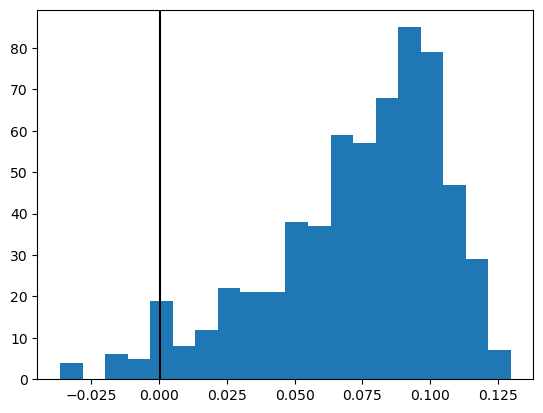

In [94]:
plt.hist(clf_if.decision_function(test), bins=20)
plt.axvline(np.min(clf_if.decision_function(test)[np.where(outliers_if_test==1)]), c='k')
plt.show()

In [95]:
min(clf_if.decision_function(test))

-0.036534802670672106